# Data cleaning

In [589]:
#import packages

# basic
import pandas as pd
import numpy as np
import pickle
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.optimize import minimize
import statsmodels.api as sm

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import RFECV

from sklearn.metrics import r2_score

# #ricequant api
# import rqdatac as rq
# rq.init()

In [590]:
##### Resample def function #####

def resample_month(df):

    # 'date' is not a column and thus can't be used to resample, need to change to a column
    # reset the index, cancel MultiIndex
    df_reset = df.reset_index()

    # set 'date' into datetime format
    df_reset['date'] = pd.to_datetime(df_reset['date'])
    
    # set 'date' as new index
    df_reset.set_index('date', inplace=True)

    resampled_data = {}
    
    for order_book_id, group in df_reset.groupby('order_book_id'):
        resampled_data[order_book_id] = group.resample("ME").last()
    
    monthly_data = pd.DataFrame(
    pd.concat(resampled_data.values(), 
              keys = resampled_data.keys(), 
              names = ['order_book_id', 'date']))
    
    # drop repeated 'order_book_id' column
    monthly_data.drop(['order_book_id'],axis = 1, inplace = True)
    
    return monthly_data

## import data

In [553]:
##### import price data #####
path = '/Users/lucyyang/Desktop/FYP/Data/'

#CSI300 price
pkl_data = open(path + 'sh50_price.pkl', 'rb')
price_data = pickle.load(pkl_data)

# re-organize the DataFrame in ascending ‘order_book_id’ order
price_data = price_data.sort_index(level=0,ascending=True)


# add risk free rate（the unit is %, thus should be divided by 100)
rf = pd.read_excel('/Users/lucyyang/Desktop/FYP/Data/rf.xlsx').set_index('date')/100

add_rf_reset = price_data.reset_index()

# Map "risk free rate"
add_rf_reset['rf_yearly'] = add_rf_reset['date'].map(rf['risk free rate'])

# Forward-fill missing values in 'rf' column
add_rf_reset['rf_yearly'] = add_rf_reset['rf_yearly'].ffill()

add_rf_reset['rf'] = add_rf_reset['rf_yearly']/12

# Restore the original index structure
add_rf_updated = add_rf_reset.set_index(['order_book_id', 'date'])

price_data = add_rf_updated
price_data

high      low  limit_up  num_trades  \
order_book_id date                                                 
600028.XSHG   2012-07-02   2.5176   2.4701    2.7432      7308.0   
              2012-07-03   2.5018   2.4661    2.7235      4891.0   
              2012-07-04   2.5018   2.4701    2.7314      5387.0   
              2012-07-05   2.4780   2.4147    2.7274     10737.0   
              2012-07-06   2.4226   2.3751    2.6601     13218.0   
...                           ...      ...       ...         ...   
688981.XSHG   2023-06-26  51.5600  49.8200   60.9600     53981.0   
              2023-06-27  51.7100  50.9000   61.1600     33087.0   
              2023-06-28  52.3800  50.7500   61.6700     44697.0   
              2023-06-29  51.9700  50.8600   62.0600     32773.0   
              2023-06-30  51.5200  50.4500   61.2000     39510.0   

                          total_turnover      volume  prev_close  limit_down  \
order_book_id date                                                             
600028.XSHG   2012-07-02    1.159515e+08  23974883.4        6.30      2.2445   
              2012-07-03    9.769380e+07  20229225.9        6.25      2.2286   
              2012-07-04    1.074469e+08  22253263.5        6.27      2.2326   
              2012-07-05    1.840997e+08  38772271.2        6.26      2.2286   
              2012-07-06    2.242892e+08  48082619.0        6.11      2.1772   
...                                  ...         ...         ...         ...   
688981.XSHG   2023-06-26    1.645373e+09  32522939.0       50.80     40.6400   
              2023-06-27    9.992826e+08  19461742.0       50.97     40.7800   
              2023-06-28    1.466379e+09  28330720.0       51.39     41.1100   
              2023-06-29    1.022845e+09  19861971.0       51.72     41.3800   
              2023-06-30    1.249845e+09  24584993.0       51.00     40.8000   

                             open    close  rf_yearly        rf  
order_book_id date                                               
600028.XSHG   2012-07-02   2.5097   2.4741   0.021034  0.001753  
              2012-07-03   2.4741   2.4820   0.021162  0.001764  
              2012-07-04   2.4899   2.4780   0.021058  0.001755  
              2012-07-05   2.4741   2.4186   0.020773  0.001731  
              2012-07-06   2.4147   2.4068   0.020404  0.001700  
...                           ...      ...        ...       ...  
688981.XSHG   2023-06-26  50.6600  50.9700   0.016910  0.001409  
              2023-06-27  50.9000  51.3900   0.016780  0.001398  
              2023-06-28  51.8700  51.7200   0.016841  0.001403  
              2023-06-29  51.2300  51.0000   0.016610  0.001384  
              2023-06-30  50.7500  50.5200   0.016535  0.001378  

[116154 rows x 12 columns]

In [492]:
monthly_price['close'].to_excel('/Users/lucyyang/Desktop/close.xlsx')

In [554]:
##### daily data -> monthly data #####

# use resample fucntion
monthly_price = resample_month(price_data)

##### calculate monthly return #####
# groupby -> order_book_id
grouped = monthly_price.groupby(level='order_book_id')

# calculate every stock return into DataFrame
for name, group in grouped:
    
    #calculate monthly return
    group['pct_ret'] = group['close'].pct_change()
    group['log_ret'] = np.log(group['close']/group['close'].shift(1))
    
    #add into monthly_price DataFrame
    monthly_price.loc[group.index, 'pct_ret'] = group['pct_ret']
    monthly_price.loc[group.index, 'log_ret'] = group['log_ret']
    
    #set regression target
    monthly_price.loc[group.index, 'log_target'] = group['log_ret'].shift(-1)
    #change risk free rate to log risk free rate(monthly)
    monthly_price.loc[group.index, 'rf_target'] = np.log(group['rf'] + 1).shift(-1)
    
monthly_price['excess_ret_target'] = monthly_price['log_target'] - monthly_price['rf_target']

# drop repeated 'order_book_id' column
monthly_price.drop(['limit_up','limit_down','prev_close','open','high','low'],axis = 1,inplace = True)


# Calculate the number of records for each order_book_id
counts = monthly_price.groupby(level=0).size()

# Filter order_book_ids with records count greater than or equal to 11 years( 11x12 = 132)
valid_ids = counts[counts >= 132].index
not_good_id = counts[counts < 132].index
# Keep the data for the order_book_ids that meet the condition
filtered_monthly_price = monthly_price.loc[valid_ids]

# Print the number of order_book_ids that meet the condition
print(f"Number of order_book_ids that meet the condition: {len(valid_ids)}")
print(not_good_id)
# Print the filtered data
filtered_monthly_price = filtered_monthly_price.dropna()

filtered_monthly_price

Number of order_book_ids that meet the condition: 38
Index(['600905.XSHG', '601225.XSHG', '601728.XSHG', '603259.XSHG',
       '603288.XSHG', '603501.XSHG', '603799.XSHG', '603986.XSHG',
       '688041.XSHG', '688111.XSHG', '688599.XSHG', '688981.XSHG'],
      dtype='object', name='order_book_id')


num_trades  total_turnover       volume   close  \
order_book_id date                                                          
600028.XSHG   2012-08-31      4150.0      82964952.0   17749358.9  2.3909   
              2012-09-30      7414.0     128013689.0   27974898.9  2.4104   
              2012-10-31      4162.0     100903155.0   21046699.7  2.5070   
              2012-11-30      6220.0      60308893.0   13056538.3  2.4225   
              2012-12-31     12694.0     358031866.0   67541962.8  2.7846   
...                              ...             ...          ...     ...   
601988.XSHG   2023-01-31     31277.0     285709655.0   88604596.0  3.0328   
              2023-02-28     18042.0     274898437.0   85384832.0  3.0422   
              2023-03-31     43513.0     523461861.0  154458817.0  3.1835   
              2023-04-30     56383.0     829750349.0  226704779.0  3.4566   
              2023-05-31     51973.0     803105090.0  205519842.0  3.6732   

                          rf_yearly        rf   pct_ret   log_ret  log_target  \
order_book_id date                                                              
600028.XSHG   2012-08-31   0.025269  0.002106 -0.001670 -0.001672    0.008123   
              2012-09-30   0.027160  0.002263  0.008156  0.008123    0.039294   
              2012-10-31   0.027921  0.002327  0.040076  0.039294   -0.034287   
              2012-11-30   0.028617  0.002385 -0.033706 -0.034287    0.139304   
              2012-12-31   0.027821  0.002318  0.149474  0.139304    0.021459   
...                             ...       ...       ...       ...         ...   
601988.XSHG   2023-01-31   0.017856  0.001488  0.018983  0.018805    0.003095   
              2023-02-28   0.020605  0.001717  0.003099  0.003095    0.045400   
              2023-03-31   0.019006  0.001584  0.046447  0.045400    0.082304   
              2023-04-30   0.019541  0.001628  0.085786  0.082304    0.060778   
              2023-05-31   0.017101  0.001425  0.062663  0.060778    0.002556   

                          rf_target  excess_ret_target  
order_book_id date                                      
600028.XSHG   2012-08-31   0.002261           0.005862  
              2012-09-30   0.002324           0.036970  
              2012-10-31   0.002382          -0.036669  
              2012-11-30   0.002316           0.136988  
              2012-12-31   0.002258           0.019200  
...                             ...                ...  
601988.XSHG   2023-01-31   0.001716           0.001379  
              2023-02-28   0.001583           0.043818  
              2023-03-31   0.001627           0.080677  
              2023-04-30   0.001424           0.059354  
              2023-05-31   0.001377           0.001179  

[4940 rows x 11 columns]

In [555]:
# Assuming filtered_monthly_price is already defined and sorted by index
filtered_monthly_price = filtered_monthly_price.sort_index()

# Function to calculate 3-sigma bounds and replace outliers
def replace_outliers(df):
    # Calculate mean and standard deviation
    mean = df['excess_ret_target'].mean()
    std = df['excess_ret_target'].std()
    
    # Calculate lower and upper bounds
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    # Find outliers
    outliers = df[(df['excess_ret_target'] < lower_bound) | (df['excess_ret_target'] > upper_bound)]
    outliers_info = pd.DataFrame({
        'Lower Bound': [lower_bound] * len(outliers),
        'Upper Bound': [upper_bound] * len(outliers),
        'Original Value': outliers['excess_ret_target']
    }, index=outliers.index)  # Set the index as the original multi-level index

    # Replace outliers with bounds
    df['excess_ret_target'] = df['excess_ret_target'].apply(
        lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
    )
    
    outliers_info = pd.DataFrame({
        'Lower Bound': [lower_bound] * len(outliers),
        'Upper Bound': [upper_bound] * len(outliers),
        'Original Value': outliers['excess_ret_target'],
        'New Replaced Value':df['excess_ret_target']
    }, index=outliers.index)  # Set the index as the original multi-level index
        
    return df, outliers_info

# Apply the outlier handling function group-by-group
result_dfs = []
outliers_logs = []
for name, group in filtered_monthly_price.groupby(level=0):
    handled_df, outliers_log = replace_outliers(group)
    result_dfs.append(handled_df)
    outliers_logs.append(outliers_log)

# Concatenate the processed data
filtered_monthly_price_cleaned = pd.concat(result_dfs)
outliers_info_df = pd.concat(outliers_logs)

# Reset the index for the cleaned DataFrame but retain the original multi-level index for the outliers info
filtered_monthly_price_cleaned.sort_index(inplace=True)
filtered_monthly_price_cleaned

num_trades  total_turnover       volume   close  \
order_book_id date                                                          
600028.XSHG   2012-08-31      4150.0      82964952.0   17749358.9  2.3909   
              2012-09-30      7414.0     128013689.0   27974898.9  2.4104   
              2012-10-31      4162.0     100903155.0   21046699.7  2.5070   
              2012-11-30      6220.0      60308893.0   13056538.3  2.4225   
              2012-12-31     12694.0     358031866.0   67541962.8  2.7846   
...                              ...             ...          ...     ...   
601988.XSHG   2023-01-31     31277.0     285709655.0   88604596.0  3.0328   
              2023-02-28     18042.0     274898437.0   85384832.0  3.0422   
              2023-03-31     43513.0     523461861.0  154458817.0  3.1835   
              2023-04-30     56383.0     829750349.0  226704779.0  3.4566   
              2023-05-31     51973.0     803105090.0  205519842.0  3.6732   

                          rf_yearly        rf   pct_ret   log_ret  log_target  \
order_book_id date                                                              
600028.XSHG   2012-08-31   0.025269  0.002106 -0.001670 -0.001672    0.008123   
              2012-09-30   0.027160  0.002263  0.008156  0.008123    0.039294   
              2012-10-31   0.027921  0.002327  0.040076  0.039294   -0.034287   
              2012-11-30   0.028617  0.002385 -0.033706 -0.034287    0.139304   
              2012-12-31   0.027821  0.002318  0.149474  0.139304    0.021459   
...                             ...       ...       ...       ...         ...   
601988.XSHG   2023-01-31   0.017856  0.001488  0.018983  0.018805    0.003095   
              2023-02-28   0.020605  0.001717  0.003099  0.003095    0.045400   
              2023-03-31   0.019006  0.001584  0.046447  0.045400    0.082304   
              2023-04-30   0.019541  0.001628  0.085786  0.082304    0.060778   
              2023-05-31   0.017101  0.001425  0.062663  0.060778    0.002556   

                          rf_target  excess_ret_target  
order_book_id date                                      
600028.XSHG   2012-08-31   0.002261           0.005862  
              2012-09-30   0.002324           0.036970  
              2012-10-31   0.002382          -0.036669  
              2012-11-30   0.002316           0.136988  
              2012-12-31   0.002258           0.019200  
...                             ...                ...  
601988.XSHG   2023-01-31   0.001716           0.001379  
              2023-02-28   0.001583           0.043818  
              2023-03-31   0.001627           0.080677  
              2023-04-30   0.001424           0.059354  
              2023-05-31   0.001377           0.001179  

[4940 rows x 11 columns]

In [556]:
outliers_info_df

Lower Bound  Upper Bound  Original Value  \
order_book_id date                                                   
600028.XSHG   2015-03-31    -0.205483     0.216017        0.234227   
600030.XSHG   2014-11-30    -0.348624     0.358596        0.672246   
600031.XSHG   2014-11-30    -0.319331     0.325940        0.415294   
600036.XSHG   2012-11-30    -0.241803     0.261879        0.314137   
              2014-11-30    -0.241803     0.261879        0.308699   
...                               ...          ...             ...   
601919.XSHG   2015-03-31    -0.424333     0.443398        0.718734   
              2015-12-31    -0.424333     0.443398       -0.503856   
601988.XSHG   2014-10-31    -0.149042     0.158642        0.170766   
              2014-11-30    -0.149042     0.158642        0.217363   
              2015-12-31    -0.149042     0.158642       -0.221261   

                          New Replaced Value  
order_book_id date                            
600028.XSHG   2015-03-31            0.216017  
600030.XSHG   2014-11-30            0.358596  
600031.XSHG   2014-11-30            0.325940  
600036.XSHG   2012-11-30            0.261879  
              2014-11-30            0.261879  
...                                      ...  
601919.XSHG   2015-03-31            0.443398  
              2015-12-31           -0.424333  
601988.XSHG   2014-10-31            0.158642  
              2014-11-30            0.158642  
              2015-12-31           -0.149042  

[66 rows x 4 columns]

<Axes: xlabel='order_book_id,date'>

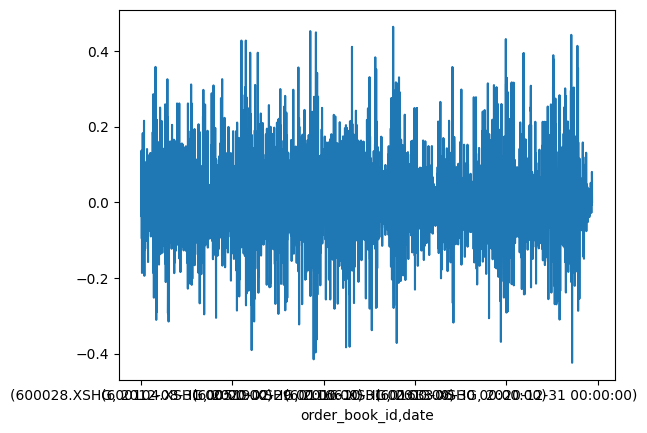

In [557]:
filtered_monthly_price_cleaned['excess_ret_target'].plot()



In [558]:
outliers_info_df

Lower Bound  Upper Bound  Original Value  \
order_book_id date                                                   
600028.XSHG   2015-03-31    -0.205483     0.216017        0.234227   
600030.XSHG   2014-11-30    -0.348624     0.358596        0.672246   
600031.XSHG   2014-11-30    -0.319331     0.325940        0.415294   
600036.XSHG   2012-11-30    -0.241803     0.261879        0.314137   
              2014-11-30    -0.241803     0.261879        0.308699   
...                               ...          ...             ...   
601919.XSHG   2015-03-31    -0.424333     0.443398        0.718734   
              2015-12-31    -0.424333     0.443398       -0.503856   
601988.XSHG   2014-10-31    -0.149042     0.158642        0.170766   
              2014-11-30    -0.149042     0.158642        0.217363   
              2015-12-31    -0.149042     0.158642       -0.221261   

                          New Replaced Value  
order_book_id date                            
600028.XSHG   2015-03-31            0.216017  
600030.XSHG   2014-11-30            0.358596  
600031.XSHG   2014-11-30            0.325940  
600036.XSHG   2012-11-30            0.261879  
              2014-11-30            0.261879  
...                                      ...  
601919.XSHG   2015-03-31            0.443398  
              2015-12-31           -0.424333  
601988.XSHG   2014-10-31            0.158642  
              2014-11-30            0.158642  
              2015-12-31           -0.149042  

[66 rows x 4 columns]

In [559]:
path = '/Users/lucyyang/Desktop/FYP/Data/'
#data123
pkl_data = open(path + 'df50fac.pkl', 'rb')
factor_data = pickle.load(pkl_data)

# Reorganize the DataFrame in ascending ‘order_book_id’ order
factor_data = factor_data.sort_index(level=0, ascending=True)

##### import factor data #####

##### daily data -> monthly data #####

# resample
monthly_factor = resample_month(factor_data)

##### Adjust DataFrame #####
# turn pb ratio into bp ratio
monthly_factor['bp_ratio_ttm'] = 1 / monthly_factor['pb_ratio_ttm']
monthly_factor.drop('pb_ratio_ttm',axis = 1,inplace = True)

# adjust the order
bp_ratio = monthly_factor.pop('bp_ratio_ttm')
monthly_factor.insert(loc = 0, column = 'bp_ratio_ttm', value = bp_ratio)

# delete columns with a lot of NaN
print(monthly_factor.columns[monthly_factor.isnull().sum() > 1000])
monthly_factor.drop(monthly_factor.columns[monthly_factor.isnull().sum() > 1000], axis = 1, inplace = True)

monthly_factor.drop(['MACR2'],axis = 1, inplace = True)
monthly_factor.drop(['RSI10'],axis = 1, inplace = True)
monthly_factor.drop(['CYR'],axis = 1, inplace = True)
monthly_factor.drop(['peg_ratio_ttm'],axis = 1, inplace = True)
monthly_factor.drop(['return_on_equity_ttm'],axis = 1, inplace = True)
monthly_factor.drop(['debt_to_asset_ratio_lf'],axis = 1, inplace = True)
monthly_factor.drop(['net_operate_cash_flow_growth_ratio_ttm'],axis = 1, inplace = True)
##### Screen 10 year data #####

# Keep the data for the order_book_ids that meet the condition
filtered_monthly_factor = monthly_factor.loc[valid_ids]

# Print the number of order_book_ids that meet the condition
print(f"Number of order_book_ids that meet the condition: {len(valid_ids)}")

Index(['gross_profit_margin_ttm', 'current_ratio_lf', 'quick_ratio_lf',
       'book_leverage_lf', 'inventory_turnover_ttm',
       'current_asset_turnover_ttm'],
      dtype='object')
Number of order_book_ids that meet the condition: 38


In [560]:
# Define X and y
y = filtered_monthly_price_cleaned['excess_ret_target']
X = filtered_monthly_factor

##### Missing Value #####

# clearing rows contains NaN
not_na = ~((X.isna()).any(axis = 1)| y.isna())
print(f"valid samples: {not_na.sum()}") 

X = X[not_na]
y = y[not_na]

##### Standard Scaling X #####

scaler = StandardScaler()
scaler_data = {}
for order_book_id, group in X.groupby('order_book_id'):
    scaler_data[order_book_id] = pd.DataFrame(scaler.fit_transform(group), 
                                              columns = X.columns,
                                              index = group.index)

# turn dict into DataFrame
X = pd.DataFrame(
    pd.concat(scaler_data.values(), 
              keys = scaler_data.keys()
)
)

# delete repeated multiIndex
X = X.droplevel(level = 0)

X

valid samples: 4967


bp_ratio_ttm  ep_ratio_ttm  sp_ratio_ttm  \
order_book_id date                                                   
600028.XSHG   2012-07-31     -0.914724      0.882910      0.598814   
              2012-08-31     -0.854202      0.402135      0.669600   
              2012-09-30     -0.822991      0.427391      0.711958   
              2012-10-31     -0.919469      0.231574      0.580294   
              2012-11-30     -0.791314      0.331169      0.754196   
...                                ...           ...           ...   
601988.XSHG   2023-02-28      1.811355      1.712261      1.525373   
              2023-03-31      1.699166      1.424217      1.218196   
              2023-04-30      1.421889      0.868495      0.855745   
              2023-05-31      1.161303      0.480346      0.476724   
              2023-06-30      1.150669      0.464506      0.461257   

                          dividend_yield_ttm  ev_to_ebitda_ttm  \
order_book_id date                                               
600028.XSHG   2012-07-31           -0.434649         -0.702059   
              2012-08-31           -0.431197         -0.509048   
              2012-09-30           -0.413765         -0.515603   
              2012-10-31           -0.494891         -0.448007   
              2012-11-30           -0.424259         -0.475691   
...                                      ...               ...   
601988.XSHG   2023-02-28            1.420699          1.057654   
              2023-03-31            1.089453          1.241386   
              2023-04-30            0.525823          1.309796   
              2023-05-31            0.138409          1.329895   
              2023-06-30            0.122599          1.330769   

                          inc_revenue_lyr  net_profit_growth_ratio_lyr  \
order_book_id date                                                       
600028.XSHG   2012-07-31         1.319397                    -0.161412   
              2012-08-31         1.319397                    -0.161412   
              2012-09-30         1.319397                    -0.161412   
              2012-10-31         1.319397                    -0.161412   
              2012-11-30         1.319397                    -0.161412   
...                                   ...                          ...   
601988.XSHG   2023-02-28         0.014889                     0.833495   
              2023-03-31        -0.992809                    -0.397352   
              2023-04-30        -0.992809                    -0.397352   
              2023-05-31        -0.992809                    -0.397352   
              2023-06-30        -0.992809                    -0.397352   

                          return_on_equity_lyr  \
order_book_id date                               
600028.XSHG   2012-07-31              2.342346   
              2012-08-31              2.342346   
              2012-09-30              2.342346   
              2012-10-31              2.342346   
              2012-11-30              2.342346   
...                                        ...   
601988.XSHG   2023-02-28             -1.059681   
              2023-03-31             -1.181931   
              2023-04-30             -1.179497   
              2023-05-31             -1.179497   
              2023-06-30             -1.179497   

                          operating_profit_growth_ratio_lyr  \
order_book_id date                                            
600028.XSHG   2012-07-31                          -0.186003   
              2012-08-31                          -0.186003   
              2012-09-30                          -0.186003   
              2012-10-31                          -0.186003   
              2012-11-30                          -0.186003   
...                                                     ...   
601988.XSHG   2023-02-28                           0.999136   
              2023-03-31                          -0.428770   
            

In [561]:
# summary statistics of the variables
summary_statistics = filtered_monthly_factor.describe().transpose()
summary_statistics = summary_statistics.iloc[:, 1:]
summary_statistics

,mean,std,min,25%,50%,75%,max
bp_ratio_ttm,0.601654,0.466129,0.024274,0.231784,0.486942,0.854729,2.610678
ep_ratio_ttm,0.074613,0.070306,-0.319715,0.028392,0.057547,0.108830,0.717807
sp_ratio_ttm,1.225971,1.630041,0.025135,0.311431,0.588940,1.311463,10.838697
dividend_yield_ttm,0.025680,0.023482,0.000000,0.009582,0.019808,0.037671,0.361702
ev_to_ebitda_ttm,36.842386,89.880542,-1181.183813,17.585372,28.137789,55.748449,1595.147595
inc_revenue_lyr,0.142708,0.203948,-0.532865,0.037494,0.118934,0.222321,1.196861
net_profit_growth_ratio_lyr,0.409515,2.264764,-5.120808,0.004991,0.124300,0.301556,35.190676
return_on_equity_lyr,0.155350,0.113637,-0.422585,0.093494,0.147694,0.212017,1.008949
operating_profit_growth_ratio_lyr,-0.070702,7.657511,-153.397127,-0.002351,0.126495,0.310713,25.199776
return_on_asset_ttm,0.084776,0.085320,-0.061379,0.021341,0.054194,0.120913,0.561558


# Simple regression

## simple OLS

In [588]:
### single OLS Regression #####

simple_reg = []

split_date = pd.Timestamp('2020-09-30')
next_split_date = pd.Timestamp('2020-10-31')

for feature in X.columns:
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]
    
    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]
    
    # Regression - Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # get r^2 and coef result
    coefficients = model.coef_[0]
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred_train = pd.Series(model.predict(X_train), 
                             index = y_train.index)
    y_pred_test = pd.Series(model.predict(X_test), 
                            index = y_test.index)
    
    # store the result
    simple_reg.append({
        ' ': feature,
        'coefficient': f"{coefficients.round(5):.5}",
        'Train R²': train_score.round(5),
        'Test R²': test_score.round(5)
    })
simple_reg = pd.DataFrame(simple_reg)
simple_reg.set_index(simple_reg.columns[0], inplace = True)

ols_train_r2 = pd.to_numeric(simple_reg['Train R²'].reset_index(drop=True)).mean()
ols_test_r2 = pd.to_numeric(simple_reg['Test R²'].reset_index(drop=True)).mean()

simple_reg.loc['ols average'] = [' ', ols_train_r2, ols_test_r2]

simple_reg

,coefficient,Train R²,Test R²
,,,
bp_ratio_ttm,0.01651,0.023130,-0.002610
ep_ratio_ttm,0.01234,0.013770,-0.010380
sp_ratio_ttm,0.01526,0.022340,0.008510
dividend_yield_ttm,0.00722,0.005080,-0.002890
ev_to_ebitda_ttm,-0.00715,0.004950,-0.001980
inc_revenue_lyr,0.00022,0.000010,-0.003220
net_profit_growth_ratio_lyr,0.00115,0.000130,-0.002850
return_on_equity_lyr,0.00021,0.000000,-0.003360
operating_profit_growth_ratio_lyr,0.00095,0.000090,-0.002950


### combi fore

In [563]:
##### single ols forecast combination #####

try_col = X.columns[0:-1]

weights = 1/len(try_col)

# Initialize a dictionary to store combined forecast
combined_forecast = {'Train_Combined': 0, 'Test_Combined': 0}

for feature in try_col:

    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]
    
    # Regression - Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # get r^2 and coef result
    coefficients = model.coef_[0]
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred_train = pd.Series(model.predict(X_train), index = y_train.index)
    y_pred_test = pd.Series(model.predict(X_test), index = y_test.index)


    # Calculate combined forecast
    combined_forecast['Train_Combined'] += weights * y_pred_train
    combined_forecast['Test_Combined'] += weights * y_pred_test

    in_sample_r2 = r2_score(y_train, combined_forecast['Train_Combined'])
    out_of_sample_r2 = r2_score(y_test, combined_forecast['Test_Combined'])

# # Convert combined forecasts to a DataFrame
# combined_forecast_df = pd.DataFrame(combined_forecast)
# combined_forecast_df

print(in_sample_r2)
print(out_of_sample_r2)

0.008597018585079108
0.0026689233593985007


In [604]:
try_col = X.columns[[2,-2]]

weights = 1/len(try_col)

# Initialize a dictionary to store combined forecast
combined_forecast = {'Train_Combined': 0, 'Test_Combined': 0}

for feature in try_col:

    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]
    
    # Regression - Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # get r^2 and coef result
    coefficients = model.coef_[0]
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred_train = pd.Series(model.predict(X_train), index = y_train.index)
    y_pred_test = pd.Series(model.predict(X_test), index = y_test.index)


    # Calculate combined forecast
    combined_forecast['Train_Combined'] += weights * y_pred_train
    combined_forecast['Test_Combined'] += weights * y_pred_test

    in_sample_r2 = r2_score(y_train, combined_forecast['Train_Combined'])
    out_of_sample_r2 = r2_score(y_test, combined_forecast['Test_Combined'])

# # Convert combined forecasts to a DataFrame
# combined_forecast_df = pd.DataFrame(combined_forecast)
# combined_forecast_df

print(in_sample_r2)
print(out_of_sample_r2)

0.016924793793160697
0.01054849465638219


## LassoCV

In [587]:
##### univariate LASSOCV regression #####
lasso_reg = []

for feature in X.columns:
    
    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]

    # Regression - LASSO
    model = LassoCV(cv = 5, max_iter = 100000000)
    model.fit(X_train, y_train)
    
    # get the best alpha value
    best_alpha = model.alpha_
    
    # get r^2 and coef result
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    coefficients = model.coef_[0]
    intercept = model.intercept_
    
    # store the result
    lasso_reg.append({
        ' ': feature,
        'coefficient': f"{coefficients:.6f}",
        'best lambda': best_alpha,
        'Train R²': f"{train_score:.6f}",
        'Test R²': test_score
    })

lasso_reg = pd.DataFrame(lasso_reg)
lasso_reg.set_index(lasso_reg.columns[0], inplace = True)

lasso_train_r2 = pd.to_numeric(lasso_reg['Train R²'].reset_index(drop=True)).mean()
lasso_test_r2 = pd.to_numeric(lasso_reg['Test R²'].reset_index(drop=True)).mean()

lasso_reg.loc['lasso average'] = [' ',' ',lasso_train_r2, lasso_test_r2]

lasso_reg

,coefficient,best lambda,Train R²,Test R²
,,,,
bp_ratio_ttm,0.016471,0.000036,0.023129,-0.002510
ep_ratio_ttm,0.012313,0.000022,0.013770,-0.010327
sp_ratio_ttm,0.015241,0.000014,0.022344,0.008519
dividend_yield_ttm,0.007079,0.000135,0.005075,-0.002790
ev_to_ebitda_ttm,-0.007143,0.000007,0.004947,-0.001980
inc_revenue_lyr,0.000000,0.000219,0.000000,-0.003288
net_profit_growth_ratio_lyr,0.000000,0.001102,0.000000,-0.003288
return_on_equity_lyr,0.000000,0.000196,0.000000,-0.003288
operating_profit_growth_ratio_lyr,0.000000,0.000948,0.000000,-0.003288


### combi fore

In [600]:
##### univariate combination LASSOCV regression #####
try_col = X.columns[0:-1]

weights = 1/len(try_col)

# Initialize a dictionary to store combined forecast
combined_forecast = {'Train_Combined': 0, 'Test_Combined': 0}

for feature in try_col:
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]

    model = LassoCV(cv = 5, max_iter = 100000000)
    model.fit(X_train, y_train)

    # get r^2 and coef result
    coefficients = model.coef_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # get the best alpha value
    best_alpha = model.alpha_
    y_pred_train = pd.Series(model.predict(X_train), index = y_train.index)
    y_pred_test = pd.Series(model.predict(X_test), index = y_test.index)

    # Calculate combined forecast
    combined_forecast['Train_Combined'] += weights * y_pred_train
    combined_forecast['Test_Combined'] += weights * y_pred_test
# print(combined_forecast['Test_Combined'])
    in_sample_r2 = r2_score(y_train, combined_forecast['Train_Combined'])
    out_of_sample_r2 = r2_score(y_test, combined_forecast['Test_Combined'])

print(in_sample_r2)
print(out_of_sample_r2)

0.008451178590320407
0.0024518405070501625


In [601]:
##### univariate combination LASSOCV regression #####
try_col = X.columns[[2,-2]]

weights = 1/len(try_col)

# Initialize a dictionary to store combined forecast
combined_forecast = {'Train_Combined': 0, 'Test_Combined': 0}

for feature in try_col:
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]

    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]

    model = LassoCV(cv = 5, max_iter = 100000000)
    model.fit(X_train, y_train)

    # get r^2 and coef result
    coefficients = model.coef_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # get the best alpha value
    best_alpha = model.alpha_
    y_pred_train = pd.Series(model.predict(X_train), index = y_train.index)
    y_pred_test = pd.Series(model.predict(X_test), index = y_test.index)

    # Calculate combined forecast
    combined_forecast['Train_Combined'] += weights * y_pred_train
    combined_forecast['Test_Combined'] += weights * y_pred_test
# print(combined_forecast['Test_Combined'])
    in_sample_r2 = r2_score(y_train, combined_forecast['Train_Combined'])
    out_of_sample_r2 = r2_score(y_test, combined_forecast['Test_Combined'])

print(in_sample_r2)
print(out_of_sample_r2)

0.016918238599430646
0.010502106479406192


## ENetCV

In [572]:
##### univariate ENetCV regression #####
enet_reg = []

for feature in X.columns:
    X_stock_feature = X[[feature]]
    
    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]
    
    # Regression - Elastic Net
    model = ElasticNetCV(cv = 5, max_iter = 100000000)
    model.fit(X_train, y_train)

    # get the best alpha value
    best_alpha = model.alpha_
    intercept = model.intercept_
    # get r^2 and coef result
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    coefficients = model.coef_[0]
    
    # store the result
    enet_reg.append({
        ' ': feature,
        'coefficient': f"{coefficients:.6f}",
        'best lambda': best_alpha,
        'Train R²': f"{train_score:.6f}",
        'Test R²': test_score
    })

enet_reg = pd.DataFrame(enet_reg)
enet_reg.set_index(enet_reg.columns[0], inplace = True)


enet_train_r2 = pd.to_numeric(enet_reg['Train R²'].reset_index(drop=True)).mean()
enet_test_r2 = pd.to_numeric(enet_reg['Test R²'].reset_index(drop=True)).mean()

enet_reg.loc['enet average'] = [' ', ' ', enet_train_r2, enet_test_r2]

enet_reg

,coefficient,best lambda,Train R²,Test R²
,,,,
bp_ratio_ttm,0.016470,0.000071,0.023129,-0.002508
ep_ratio_ttm,0.012309,0.000049,0.013770,-0.010319
sp_ratio_ttm,0.015240,0.000028,0.022344,0.008519
dividend_yield_ttm,0.007078,0.000271,0.005075,-0.002789
ev_to_ebitda_ttm,-0.007143,0.000013,0.004947,-0.001980
inc_revenue_lyr,0.000000,0.000437,0.000000,-0.003288
net_profit_growth_ratio_lyr,0.000000,0.002204,0.000000,-0.003288
return_on_equity_lyr,0.000000,0.000392,0.000000,-0.003288
operating_profit_growth_ratio_lyr,0.000000,0.001896,0.000000,-0.003288


### combi forec

In [602]:
##### univariate combination EnetCV regression #####

try_col = X.columns[0:-1]

weights = 1/len(try_col)

# Initialize a dictionary to store combined forecast
combined_forecast = {'Train_Combined': 0, 'Test_Combined': 0}

for feature in try_col:

    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]

    model = ElasticNetCV(cv = 5, max_iter = 100000000)
    model.fit(X_train, y_train)

    # get r^2 and coef result
    coefficients = model.coef_[0]
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # get the best alpha value
    best_alpha = model.alpha_
    
    y_pred_train = pd.Series(model.predict(X_train), index = y_train.index)
    y_pred_test = pd.Series(model.predict(X_test), index = y_test.index)

    # Calculate combined forecast
    combined_forecast['Train_Combined'] += weights * y_pred_train
    combined_forecast['Test_Combined'] += weights * y_pred_test

    in_sample_r2 = r2_score(y_train, combined_forecast['Train_Combined'])
    out_of_sample_r2 = r2_score(y_test, combined_forecast['Test_Combined'])

print(in_sample_r2)
print(out_of_sample_r2)

0.008450462750853371
0.002451611685314603


In [603]:
##### univariate combination EnetCV regression #####

try_col = X.columns[[2,-2]]

weights = 1/len(try_col)

# Initialize a dictionary to store combined forecast
combined_forecast = {'Train_Combined': 0, 'Test_Combined': 0}

for feature in try_col:

    X_train = X.loc[pd.IndexSlice[:,:split_date], :][[feature]]
    X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :][[feature]]

    y_train = y.loc[pd.IndexSlice[:,:split_date]]
    y_test = y.loc[pd.IndexSlice[:,next_split_date:]]

    model = ElasticNetCV(cv = 5, max_iter = 100000000)
    model.fit(X_train, y_train)

    # get r^2 and coef result
    coefficients = model.coef_[0]
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # get the best alpha value
    best_alpha = model.alpha_
    
    y_pred_train = pd.Series(model.predict(X_train), index = y_train.index)
    y_pred_test = pd.Series(model.predict(X_test), index = y_test.index)

    # Calculate combined forecast
    combined_forecast['Train_Combined'] += weights * y_pred_train
    combined_forecast['Test_Combined'] += weights * y_pred_test

    in_sample_r2 = r2_score(y_train, combined_forecast['Train_Combined'])
    out_of_sample_r2 = r2_score(y_test, combined_forecast['Test_Combined'])

print(in_sample_r2)
print(out_of_sample_r2)

0.016918090669531094
0.010501878326215186


## Result comparision

In [528]:
col_simple_reg = simple_reg.iloc[:, -1]
col_lasso_reg = lasso_reg.iloc[:, -1]
col_enet_reg = enet_reg.iloc[:, -1]

test_all_result = pd.concat([col_simple_reg, col_lasso_reg, col_enet_reg], axis=1)

test_all_result.columns = ['OLS test R²', 'LASSO test R²', 'ENet test R²']
test_all_result

,OLS test R²,LASSO test R²,ENet test R²
,,,
bp_ratio_ttm,-0.002610,-0.002510,-0.002508
ep_ratio_ttm,-0.010380,-0.010327,-0.010319
sp_ratio_ttm,0.008510,0.008519,0.008519
dividend_yield_ttm,-0.002890,-0.002790,-0.002789
ev_to_ebitda_ttm,-0.001980,-0.001980,-0.001980
inc_revenue_lyr,-0.003220,-0.003288,-0.003288
net_profit_growth_ratio_lyr,-0.002850,-0.003288,-0.003288
return_on_equity_lyr,-0.003360,-0.003288,-0.003288
operating_profit_growth_ratio_lyr,-0.002950,-0.003288,-0.003288


In [568]:
col_simple_reg = simple_reg.iloc[:, -2]
col_lasso_reg = lasso_reg.iloc[:, -2]
col_enet_reg = enet_reg.iloc[:, -2]

train_all_result = pd.concat([col_simple_reg, col_lasso_reg, col_enet_reg], axis = 1)

train_all_result.columns = ['simple train R²', 'LASSO train R²', 'ENet train R²']
train_all_result

,simple train R²,LASSO train R²,ENet train R²
,,,
bp_ratio_ttm,0.023130,0.023129,0.023129
ep_ratio_ttm,0.013770,0.013770,0.013770
sp_ratio_ttm,0.022340,0.022344,0.022344
dividend_yield_ttm,0.005080,0.005075,0.005075
ev_to_ebitda_ttm,0.004950,0.004947,0.004947
inc_revenue_lyr,0.000010,0.000000,0.000000
net_profit_growth_ratio_lyr,0.000130,0.000000,0.000000
return_on_equity_lyr,0.000000,0.000000,0.000000
operating_profit_growth_ratio_lyr,0.000090,0.000000,0.000000


# Multivariable regression
## OLS

OLS train-test split Regression
--------------------------------
train score: 0.03618381029001361
test score: -0.0052614663845085285


Text(0.5, 1.0, 'OLS prediction result')

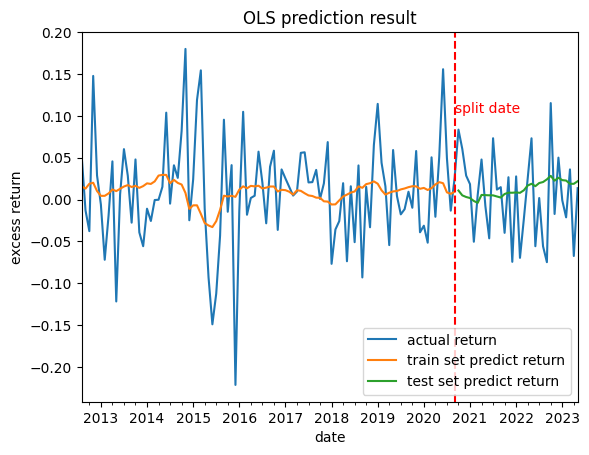

In [583]:
##### multivaraite OLS Regression #####

common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

split_date = pd.Timestamp('2020-9-30')
next_split_date = pd.Timestamp('2020-10-31')

X_train = X.loc[pd.IndexSlice[:,:split_date], :]
X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :]

y_train = y.loc[pd.IndexSlice[:,:split_date]]
y_test = y.loc[pd.IndexSlice[:,next_split_date:]]

# Regression - Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# get r^2 and coef result
coefficients = model.coef_
intercept = model.intercept_
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
y_pred_tr = model.predict(X_train)
y_pred_tr_series = pd.Series(y_pred_tr, index = y_train.index)

y_pred_tt = model.predict(X_test)
y_pred_tt_series = pd.Series(y_pred_tt, index = y_test.index)

# Create the DataFrame to store the result
OLS_results = pd.DataFrame(data = coefficients.tolist(), 
                       columns = ['coefficient'], 
                       index = X.columns)

print('OLS train-test split Regression')
print('--------------------------------')
print(f"train score: {train_score}")
print(f"test score: {test_score}")
#OLS_results


y.groupby('date').mean().plot()
y_pred_tr_series.groupby('date').mean().plot()
y_pred_tt_series.groupby('date').mean().plot()
plt.ylabel('excess return')
plt.legend(['actual return','train set predict return','test set predict return'])
plt.axvline(x='2020-09-30', color='red', linestyle='--',label = 'split date')
plt.text(pd.Timestamp(split_date), 0.1, 'split date', color='red', rotation=0, va='bottom')

plt.title('OLS prediction result')

## Lasso CV

LassoCV regression
--------------------------------
train score: 0.03142747950942604
test score: 0.001371600924632288
--------------------------------
best_alpha: 0.0021359724897208232


Text(0.5, 1.0, 'LASSOCV prediction result')

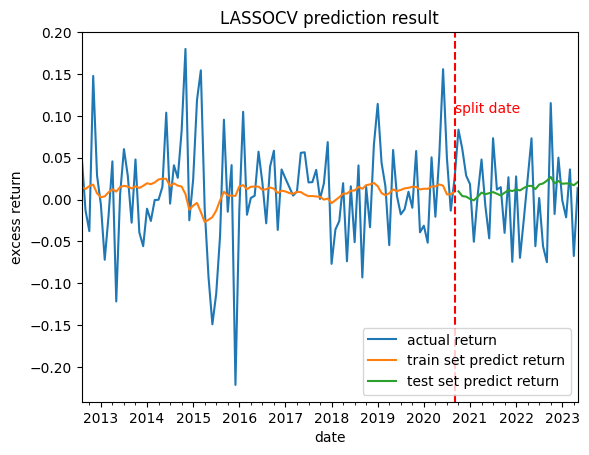

In [586]:
##### multivariate LASSO CV regression #####
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

split_date = pd.Timestamp('2020-09-30')
next_split_date = pd.Timestamp('2020-10-31')

X_train = X.loc[pd.IndexSlice[:,:split_date], :]
X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :]

y_train = y.loc[pd.IndexSlice[:,:split_date]]
y_test = y.loc[pd.IndexSlice[:,next_split_date:]]

# Regression - Linear Regression
l1_lm = LassoCV(cv = 5, max_iter = 1000000)
l1_lm.fit(X_train, y_train)

# get the best alpha value
best_alpha = l1_lm.alpha_

train_score = l1_lm.score(X_train, y_train)
test_score = l1_lm.score(X_test, y_test)

# get r^2 and coef result
coefficients = l1_lm.coef_
intercept = model.intercept_
y_pred = l1_lm.predict(X_test)

y_pred_tr = l1_lm.predict(X_train)
y_pred_tr_series = pd.Series(y_pred_tr, index = y_train.index)

y_pred_tt = l1_lm.predict(X_test)
y_pred_tt_series = pd.Series(y_pred_tt, index = y_test.index)

# Create the DataFrame to store the result

LASSOCV_results = pd.DataFrame(data = coefficients.tolist(), 
                       columns = ['coefficient'], 
                       index = X.columns)

print('LassoCV regression')
print('--------------------------------')
print(f"train score: {train_score}")
print(f"test score: {test_score}")
print('--------------------------------')
print(f"best_alpha: {best_alpha}")

#LASSOCV_results

y.groupby('date').mean().plot()
y_pred_tr_series.groupby('date').mean().plot()
y_pred_tt_series.groupby('date').mean().plot()
plt.legend(['actual return','train set predict return','test set predict return'])
plt.axvline(x='2020-09-30', color='red', linestyle='--',label = 'split date')
plt.ylabel('excess return')
plt.title('multivariate LASSO prediction result')
plt.text(pd.Timestamp(split_date), 0.1, 'split date', color='red', rotation=0, va='bottom')
plt.title('LASSOCV prediction result')

## ENet CV

ENetCV regression
--------------------------------
train score: 0.03141691853679418
test score: 0.001411078739512961
--------------------------------
best alpha: 0.004271944979441647


Text(0.5, 1.0, 'EnetCV prediction result')

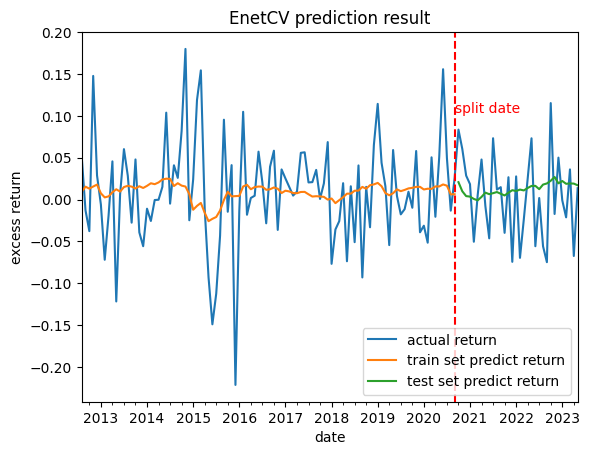

In [585]:
##### multivariate ElasticNet CV regression #####
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

split_date = pd.Timestamp('2020-09-30')
next_split_date = pd.Timestamp('2020-10-31')

X_train = X.loc[pd.IndexSlice[:,:split_date], :]
X_test = X.loc[pd.IndexSlice[:,next_split_date:,], :]

y_train = y.loc[pd.IndexSlice[:,:split_date]]
y_test = y.loc[pd.IndexSlice[:,next_split_date:]]


# Regression - Elastic Net CV
en_lm = ElasticNetCV(cv = 5, tol = 1e-4, max_iter = 1000000)
en_lm.fit(X_train, y_train)

# Get the best alpha and l1_ratio
best_alpha = en_lm.alpha_
best_l1_ratio = en_lm.l1_ratio_

# get r^2 and coef result
coefficients = en_lm.coef_
intercept = model.intercept_

train_score = en_lm.score(X_train, y_train)
test_score = en_lm.score(X_test, y_test)

y_pred_tr = en_lm.predict(X_train)
y_pred_tr_series = pd.Series(y_pred_tr, index = y_train.index)
y_pred_tr_series1 = y_pred_tr_series.shift(1)
y_pred_tt = en_lm.predict(X_test)
y_pred_tt_series = pd.Series(y_pred_tt, index = y_test.index)
y_pred_tt_series1 = y_pred_tt_series.shift(1)
# Create the DataFrame to store the result
ENetCV_results = pd.DataFrame(data = coefficients.tolist(), 
                       columns = ['coefficient'], 
                       index = X.columns)

print('ENetCV regression')
print('--------------------------------')
print(f"train score: {train_score}")
print(f"test score: {test_score}")
print('--------------------------------')
print(f"best alpha: {best_alpha}")
#ENetCV_results
y.groupby('date').mean().plot()
y_pred_tr_series1.groupby('date').mean().plot()
y_pred_tt_series1.groupby('date').mean().plot()
plt.ylabel('excess return')
plt.legend(['actual return','train set predict return','test set predict return'])
plt.axvline(x='2020-09-30', color='red', linestyle='--',label = 'split date')
plt.text(pd.Timestamp(split_date), 0.1, 'split date', color='red', rotation=0, va='bottom')
plt.title('EnetCV prediction result')